In [1]:

import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
# from scipy.optimize import curve_fit
%matplotlib widget

path = 'C:\\Researches\\Data\\CrCl3\\202201\\RIXS\\'
base = 'Cr'
energyDispersion = 0.00535 #eV/subpixel

In [2]:
def elasticShift(pixelData,zeroType,peakHeight,peakWidth):

    global energyDispersion
    if zeroType == "peak":
        peaks, _ = signal.find_peaks(pixelData,height=peakHeight,width=peakWidth)
    elif zeroType == "height":
        peaks, _ = pixelData[(pixelData>peakHeight)]
    else:
        peaks = pixelData
    xdataPixel = np.arange(len(pixelData))
    
    xdataPixel = xdataPixel[(peaks[-1]-2000):(peaks[-1]+200)]
    energyData = pixelData[(peaks[-1]-2000):(peaks[-1]+200)]
    
    xDataEnergy = (xdataPixel - peaks[-1]) * energyDispersion * -1

    return xDataEnergy,energyData

def xCorr(refData, uncorrData):

    corr = signal.correlate(refData, uncorrData)
    lag = np.argmax(corr)
    corrData = np.roll(uncorrData, lag)

    return corrData

def getData(scanNumber,zeroType='peak',peakHeight=10,peakWidth=3):
    global path
    global base
    
    if scanNumber < 10:
        filename = base+'_'+'000'+str(scanNumber)
    elif scanNumber < 100:
        filename = base+'_'+'00'+str(scanNumber)
    elif scanNumber < 1000:    
        filename = base+'_'+'0'+str(scanNumber)
    else:    
        filename = base+'_'+str(scanNumber)

    f1 = h5py.File(path+filename+'_d1.h5', 'r')
    f2 = h5py.File(path+filename+'_d2.h5', 'r')
    f3 = h5py.File(path+filename+'_d3.h5', 'r')

    ccd1 = np.array(f1['entry']['analysis']['spectrum'][()])
    ccd2 = np.array(f2['entry']['analysis']['spectrum'][()])
    ccd3 = np.array(f3['entry']['analysis']['spectrum'][()])
    
    ccd1 = xCorr(ccd2,ccd1)
    ccd3 = xCorr(ccd2,ccd3)
    xdata,tempData = elasticShift(ccd1+ccd2+ccd3,zeroType,peakHeight,peakWidth)
    
    return xdata,tempData

def getScans(scans,zeroType='peak',peakHeight=10,peakWidth=3):
    for i,scanNumber in enumerate(scans):
        if i == 0:
            xdata,ydata = getData(scanNumber,zeroType=zeroType,peakHeight=peakHeight,peakWidth=peakWidth)
            refdata = ydata
            sumdata = ydata
        else:
            _,ydata = getData(scanNumber,zeroType=zeroType,peakHeight=peakHeight)
            ydata = xCorr(refdata,ydata)
            sumdata = sumdata+ydata
    return xdata,sumdata


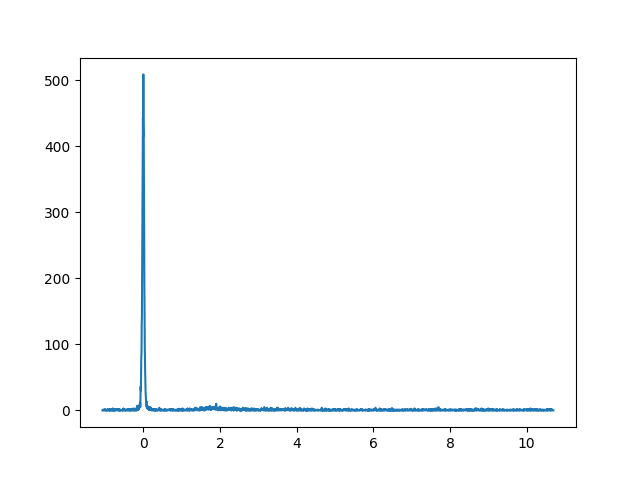

In [3]:
fig = plt.figure()
X,Y=getData(105)
plt.plot(X,Y);

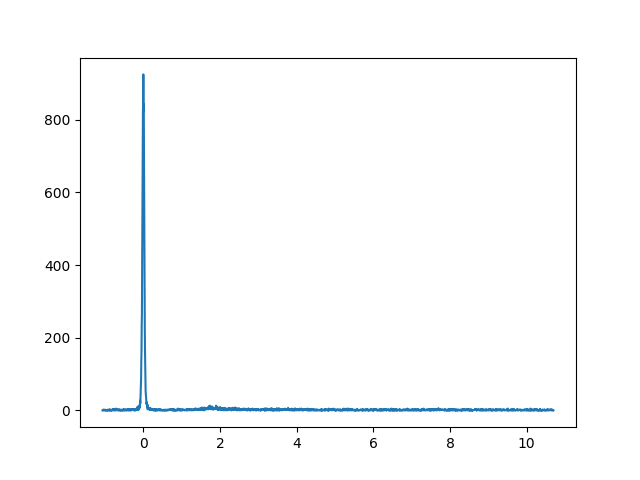

In [4]:
fig = plt.figure()
X,Y=getScans([105,106])
plt.plot(X,Y);

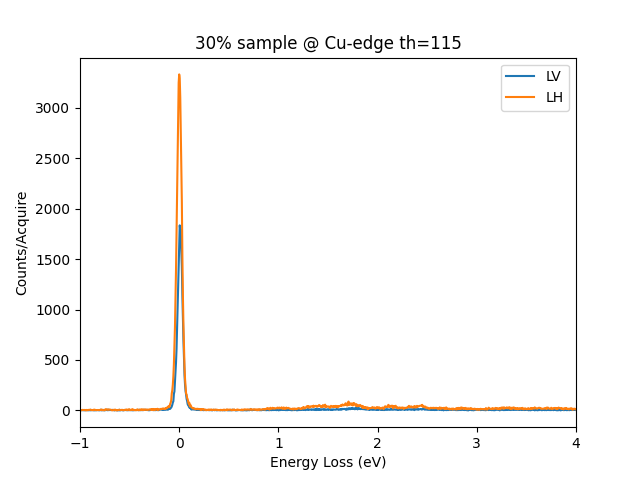

In [5]:
fig = plt.figure() 

#####################################

scans = range(289,293+1)
X,Y=getScans(scans)
plt.plot(X,Y,  label='LV')

######################################

scans = range(442,446+1)
X,Y=getScans(scans)
plt.plot(X,Y, label='LH')

######################################

plt.xlabel('Energy Loss (eV)')
plt.ylabel('Counts/Acquire')
plt.xlim([-1,4])
plt.title('30% sample @ Cu-edge th=115')
plt.legend();

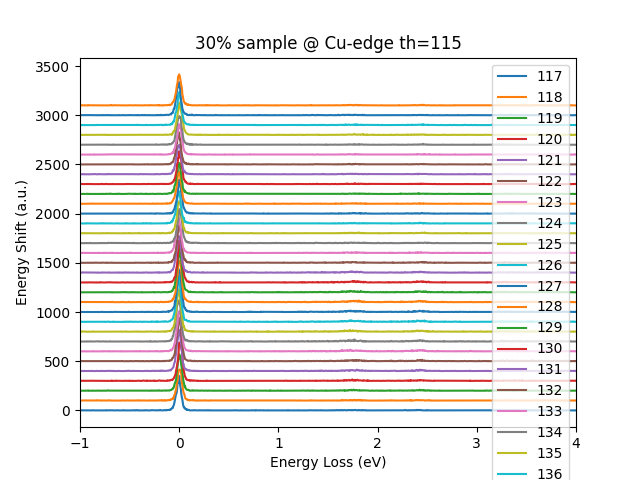

In [6]:
fig = plt.figure()

scans = range(117,148+1)

for i,s in enumerate(scans):
    xData,oneData = getData(s)
    plt.plot(xData,oneData+100*i,label=str(s))

plt.xlabel('Energy Loss (eV)')
plt.ylabel('Energy Shift (a.u.)')
plt.xlim([-1,4])
plt.title('30% sample @ Cu-edge th=115')
plt.legend(loc='upper right');

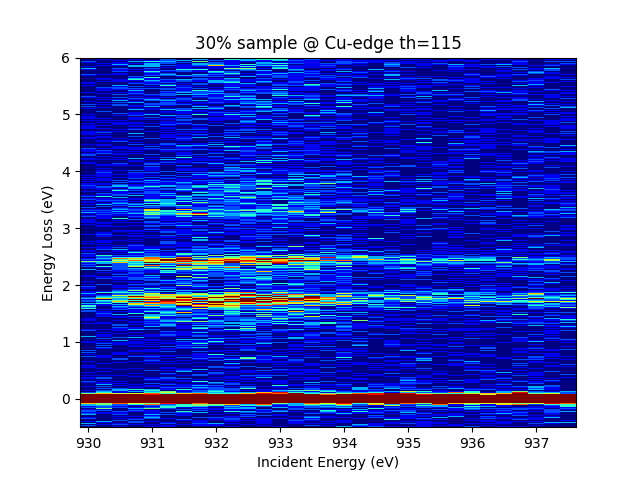

In [7]:
fig = plt.figure()

scans = range(117,147+1)
Ei = np.arange(930,937.5+0.1,0.25)
eiNum = len(scans)

matrixData = np.zeros((2200, eiNum))

for i,s in enumerate(scans):
    Eloss,oneData = getData(s)
    matrixData[:,i] = oneData.T

X,Y = np.meshgrid(Ei,Eloss)

plt.pcolormesh(X,Y,matrixData,shading='auto',cmap='jet',vmax=10)
plt.ylim([-0.5,6])
plt.xlabel('Incident Energy (eV)')
plt.ylabel('Energy Loss (eV)')
plt.title('30% sample @ Cu-edge th=115');